<a href="https://colab.research.google.com/github/DFIC-Quant-Fund/CompVision-W2024/blob/main/ImageGenerationScript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed


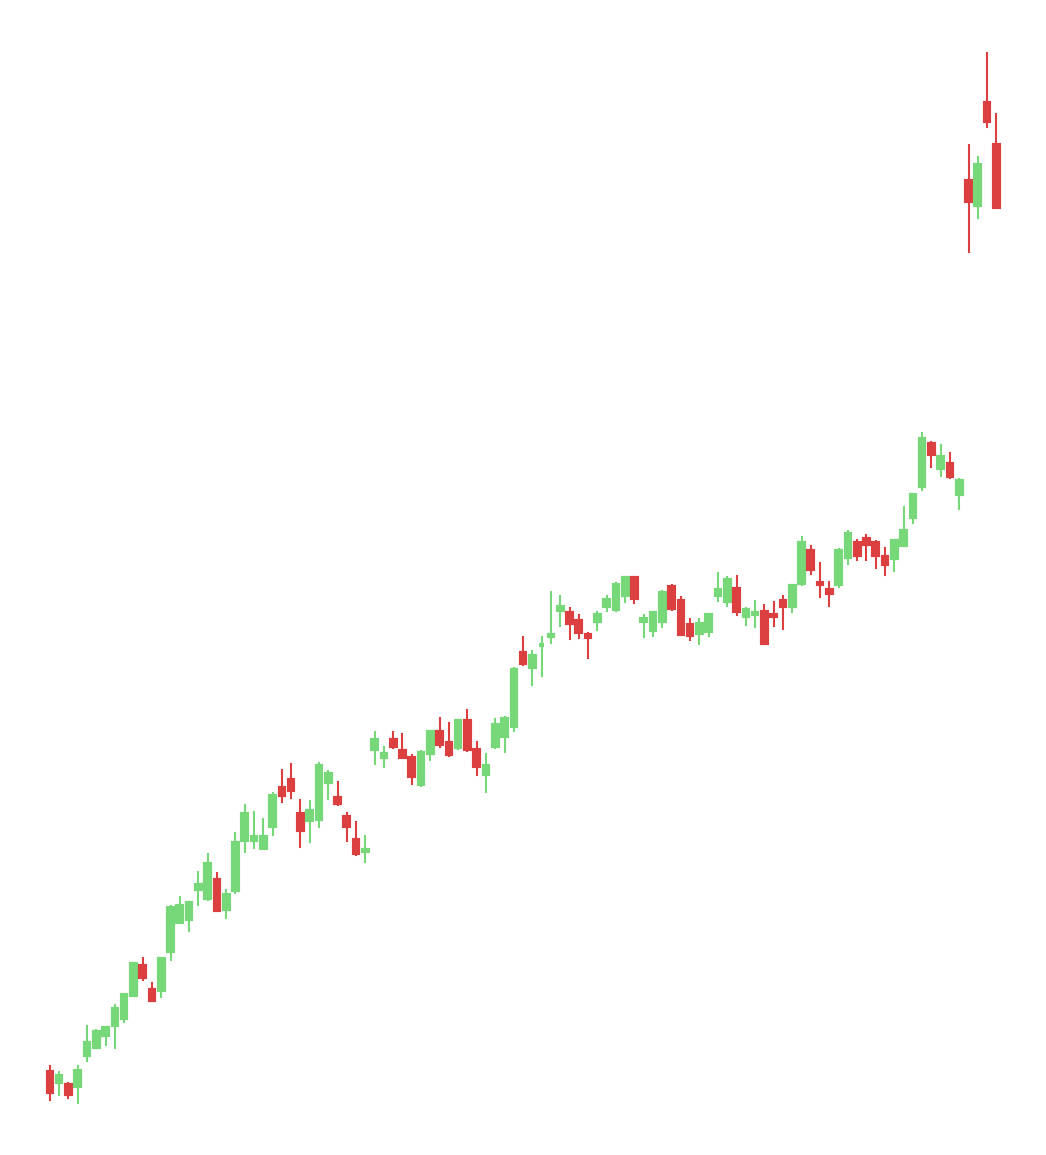

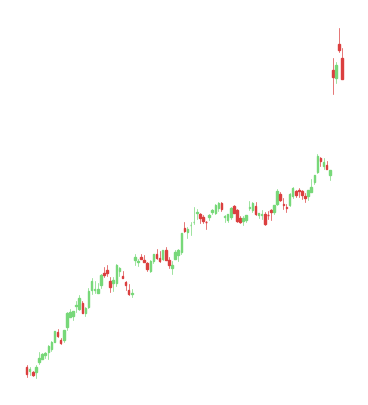

In [ ]:
# Uncomment if you have not installed yet
# !pip install yfinance
# !pip install matplotlib
!pip install mplfinance
# !pip install numpy
# !pip install pillow

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
from PIL import Image

stock_symbol = 'NVDA'
start_date = '2023-01-01'
end_date = '2023-06-01'

stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
stock_data.reset_index(inplace=True)
stock_data['NumericDate'] = np.arange(len(stock_data))

ohlc = stock_data[['NumericDate', 'Open', 'High', 'Low', 'Close', 'Volume']].values

fig_width = 4.5
fig_height = 5
fig, ax1 = plt.subplots(figsize=(fig_width, fig_height))

candlestick_ohlc(ax1, ohlc, width=0.5, colorup='#77d879', colordown='#db3f3f')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax1.axis('off')
ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('')

plt.savefig('chart.png', bbox_inches='tight', pad_inches=0, dpi=300)


display(Image.open("chart.png"))


In [ ]:


def convert_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img_data = np.array(img)

    white_condition = (img_data[..., 0] > 200) & (img_data[..., 1] > 200) & (img_data[..., 2] > 200)
    red_condition = img_data[..., 0] > 200
    green_condition = img_data[..., 1] > 200

    rounded_data = np.where(white_condition[:, :, np.newaxis], [255, 255, 255],
                            np.where(red_condition[:, :, np.newaxis], [255, 0, 0],
                                     np.where(green_condition[:, :, np.newaxis], [0, 255, 0], img_data)))

    rounded_img = Image.fromarray(rounded_data.astype(np.uint8))
    return rounded_img

input_image_path = "chart.png"
output_image_path = "chart2.png"
rounded_image = convert_image(input_image_path)
rounded_image.save(output_image_path)

display(Image.open("chart2.png"))


In [ ]:
from PIL import Image
import numpy as np

def png_to_hex_array(image_path):
    image = Image.open(image_path)
    image_rgba = image.convert("RGBA")
    width, height = image_rgba.size

    pixel_data = np.array(image_rgba.getdata(), dtype=np.uint8).reshape((height, width, 4))
    hex_colors = np.reshape(['#' + ''.join(f'{c:02x}' for c in row) for row in pixel_data.reshape(-1, pixel_data.shape[-1])], pixel_data.shape[0:2])

    return hex_colors

def hex_array_to_image(hex_colors):
    height, width = hex_colors.shape
    new_image = Image.new("RGBA", (width, height))

    for y in range(height):
        for x in range(width):
            r, g, b, a = [int(hex_colors[y, x][i:i+2], 16) for i in (1, 3, 5, 7)]
            new_image.putpixel((x, y), (r, g, b, a))

    return new_image

def slim_high_and_low(image_path):
    hex_colors = png_to_hex_array(image_path)
    for i in range(hex_colors.shape[0]):
        if '#ffffffff' in hex_colors[i]:
            index = list(hex_colors[i]).index('#ffffffff')
            if index != 0 and hex_colors[i][index-1] != '#ffffffff':
                hex_colors[i][index-1] = '#ffffffff'
    slimmed = hex_array_to_image(hex_colors)
    slimmed.save("chart3.png")

slim_high_and_low('chart2.png')

display(Image.open("chart3.png"))

In [ ]:
from PIL import Image

def png_to_hex_array(image_path):
    image = Image.open(image_path)
    image_rgba = image.convert("RGBA")
    width, height = image_rgba.size
    pixel_data = list(image_rgba.getdata())
    hex_colors = [[0 for _ in range(width)] for _ in range(height)]
    for y in range(height):
        for x in range(width):
            r, g, b, a = pixel_data[y * width + x]
            hex_colors[y][x] = '#{0:02x}{1:02x}{2:02x}{3:02x}'.format(r, g, b, a)
    return hex_colors

def hex_array_to_image(hex_colors):
    height = len(hex_colors)
    width = len(hex_colors[0])
    new_image = Image.new("RGBA", (width, height))

    for y in range(height):
        for x in range(width):
            hex_color = hex_colors[y][x]
            rgba = tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5, 7))
            new_image.putpixel((x, y), rgba)

    return new_image


def slim_high_and_low(image_path):
    to_change = []
    hex_colors = png_to_hex_array(image_path)
    main_color = ''
    stage = 0
    for i in range(len(hex_colors)):
        skip_flag = 0
        for j in range(len(hex_colors[0])):
            if skip_flag > 0:
                skip_flag -= 1
                continue
            color = hex_colors[i][j]
            if stage == 0 and color == '#ffffffff':
                stage = 1
            elif stage == 1 and color != '#ffffffff':
                main_color = color
                if hex_colors[i][j:j+7] == [main_color for _ in range(7)]:
                    skip_flag = 7
                    to_change.append((i, j))
                    to_change.append((i, j+1))
                    to_change.append((i, j+5))
                    to_change.append((i, j+6))
                    to_change.append((i, j+7))


            elif stage == 1 and color == '#ffffffff':
                pass


            elif stage == 3 and color == '#ffffffff':
                to_change.append((i, j-1))
                stage = 0
            else:
                stage = 0
        stage = 0
    for pair in to_change:
        i, j = pair
        hex_colors[i][j] = '#ffffffff'


    slimmed = hex_array_to_image(hex_colors)
    slimmed.save("chart4.png")



slim_high_and_low('chart3.png')

display(Image.open("chart4.png"))


In [ ]:
from PIL import Image


def png_to_hex_array(image_path):
    image = Image.open(image_path)
    image_rgba = image.convert("RGBA")
    width, height = image_rgba.size
    pixel_data = list(image_rgba.getdata())
    hex_colors = [[0 for _ in range(width)] for _ in range(height)]
    for y in range(height):
        for x in range(width):
            r, g, b, a = pixel_data[y * width + x]
            hex_colors[y][x] = '#{0:02x}{1:02x}{2:02x}{3:02x}'.format(r, g, b, a)
    return hex_colors

def hex_array_to_image(hex_colors):
    height = len(hex_colors)
    width = len(hex_colors[0])
    new_image = Image.new("RGBA", (width, height))

    for y in range(height):
        for x in range(width):
            hex_color = hex_colors[y][x]
            rgba = tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5, 7))
            new_image.putpixel((x, y), rgba)

    return new_image



def png_to_hex_array_remove_white(image_path):
    hex_colors = png_to_hex_array(image_path)
    hex_colors = [col for col in zip(*hex_colors) if not all(px == '#ffffffff' for px in col)]
    hex_colors = list(map(list, zip(*hex_colors)))


    columned = hex_array_to_image(hex_colors)
    columned.save("chart5.png")



png_to_hex_array_remove_white('chart4.png')

display(Image.open("chart5.png"))



In [ ]:
def png_to_hex_array(image_path):
    image = Image.open(image_path)
    image_rgba = image.convert("RGBA")
    width, height = image_rgba.size
    pixel_data = list(image_rgba.getdata())
    hex_colors = [[0 for _ in range(width)] for _ in range(height)]
    for y in range(height):
        for x in range(width):
            r, g, b, a = pixel_data[y * width + x]
            hex_colors[y][x] = '#{0:02x}{1:02x}{2:02x}{3:02x}'.format(r, g, b, a)
    return hex_colors


def crop_image_top(image_path):
    colors = png_to_hex_array(image_path)
    top_pixels = 0
    for i, row in enumerate(colors):
        only_white = True
        for color in row:
            if color != '#ffffffff':
                only_white = False
                break
        if only_white:
            top_pixels += 1
        if not only_white:
            break

    image = Image.open("chart5.png")

    width, height = image.size
    cropped_image = image.crop((0, top_pixels, width, height))
    cropped_image.save("chart6.png")

def crop_image_bottom(image_path):
    colors = png_to_hex_array(image_path)
    bottom_pixels = 0
    for i, row in enumerate(colors[::-1]):
        only_white = True
        for color in row:
            if color != '#ffffffff':
                only_white = False
                break
        if only_white:
            bottom_pixels += 1
        if not only_white:
            break

    image = Image.open("chart6.png")
    width, height = image.size
    cropped_image = image.crop((0, 0, width, height - bottom_pixels))
    cropped_image.save("chart7.png")


crop_image_top('chart5.png')
crop_image_bottom('chart6.png')



display(Image.open("chart7.png"))


# Future steps are to change size of image based on the high and low price
# make images much smaller, crop the sides of the images
# make candles 3 pixels from open to close, 1 pixel from high and low

FileNotFoundError: [Errno 2] No such file or directory: 'chart5.png'

[*********************100%%**********************]  1 of 1 completed


Time to generate graph: 4.308985426000163
Time to crop image top: 4.422559265000018
Time to crop image bottom: 4.520350656000119
Time to binarize data: 8.247046240000145
Time to slim high and low data: 12.16843623900013
Time to slim open and close data: 16.14581724000027
Time to remove white columns: 17.260075530999984
Total Time: 17.26153977900003 seconds


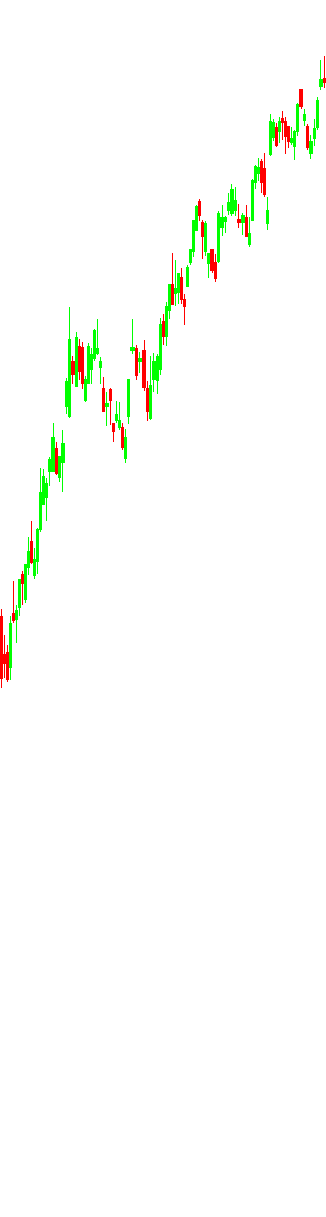

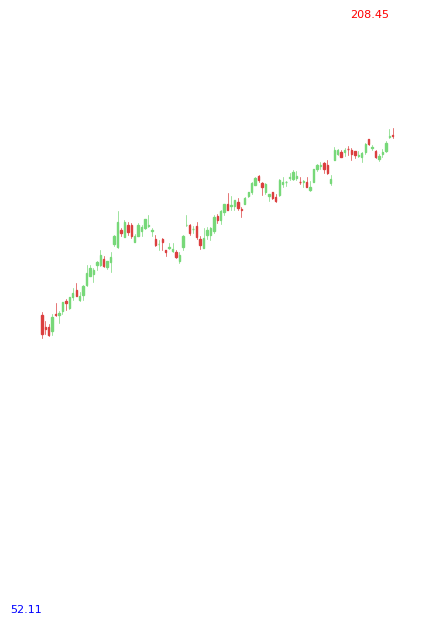

In [32]:
# !pip install mplfinance

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
from PIL import Image
from time import perf_counter
class Graph:
    def __init__(self, stock_symbol='NVDA', start_date='2023-01-01', end_date='2023-03-01', stock_data=None):
        self.stock_data = stock_data
        self.stock_symbol = stock_symbol
        self.start_date = start_date
        self.end_date = end_date
        self.image_array = []
        self.crop_pixels = 300
        self.pips = 0.6

    def generate_graph(self):
        if self.stock_data is None:
            self.stock_data = yf.download(self.stock_symbol, start=self.start_date, end=self.end_date)

        self.stock_data.reset_index(inplace=True)
        self.stock_data['NumericDate'] = np.arange(len(self.stock_data))

        ohlc = self.stock_data[['NumericDate', 'Open', 'High', 'Low', 'Close', 'Volume']].values

        start_price_adj = self.stock_data.iloc[0]['Open'] * (1-self.pips)
        end_price_adj = self.stock_data.iloc[0]['Open'] * (1+self.pips)
        fig_width = 10/2
        fig_height = 3
        fig, ax1 = plt.subplots(figsize=(fig_width, fig_height))

        candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f')

        ax1.text(-0.02, start_price_adj, f'{start_price_adj:.2f}', color='blue', ha='right', fontsize=8)
        ax1.text(len(self.stock_data) - 1.98, end_price_adj, f'{end_price_adj:.2f}', color='red', ha='right', fontsize=8)

        ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        ax1.axis('off')
        ax1.set_title('')
        ax1.set_xlabel('')
        ax1.set_ylabel('')

        plt.savefig('chart.png', bbox_inches='tight', pad_inches=0, dpi=300)
        self.image_array = self.png_to_hex_array('chart.png')

    def png_to_hex_array(self, image_path):
        image = Image.open(image_path)
        image_rgba = image.convert("RGBA")
        width, height = image_rgba.size
        pixel_data = list(image_rgba.getdata())
        hex_colors = [[0 for _ in range(width)] for _ in range(height)]
        for y in range(height):
            for x in range(width):
                r, g, b, a = pixel_data[y * width + x]
                hex_colors[y][x] = '#{0:02x}{1:02x}{2:02x}{3:02x}'.format(r, g, b, a)
        return hex_colors

    def hex_array_to_image(self, hex_colors):
        height = len(hex_colors)
        width = len(hex_colors[0])
        image_data = np.empty((height, width, 4), dtype=np.uint8)

        for y, row in enumerate(hex_colors):
            rgba_values = [tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5, 7)) for hex_color in row]
            image_data[y, :] = rgba_values

        new_image = Image.fromarray(image_data, 'RGBA')
        return new_image

    def binarize(self):
        img = Image.open("chart.png").convert('RGB')
        img_data = np.array(img)

        white_condition = (img_data[..., 2] > 200)
        red_condition = img_data[..., 0] > 200
        green_condition = img_data[..., 1] > 200

        rounded_data = np.where(white_condition[:, :, np.newaxis], [255, 255, 255],
                                np.where(red_condition[:, :, np.newaxis], [255, 0, 0],
                                        np.where(green_condition[:, :, np.newaxis], [0, 255, 0], img_data)))

        rounded_img = Image.fromarray(rounded_data.astype(np.uint8))
        rounded_img.save("chart.png")
        self.image_array = self.png_to_hex_array('chart.png')



    def slim_high_and_low(self):
        to_change = []
        hex_colors = self.image_array
        main_color = ''
        stage = 0
        for i in range(len(hex_colors)):
            for j in range(len(hex_colors[0])):
                color = hex_colors[i][j]
                if stage == 0 and color == '#ffffffff':
                    stage = 1
                elif stage == 1 and color != '#ffffffff':
                    main_color = color
                    stage = 2
                elif stage == 1 and color == '#ffffffff':
                    pass
                elif stage == 2 and color == main_color:
                    stage = 3
                elif stage == 2 and color == '#ffffffff':
                    stage = 1
                elif stage == 3 and color == '#ffffffff':
                    to_change.append((i, j-1))
                    stage = 0
                else:
                    stage = 0
            stage = 0
        for pair in to_change:
            i, j = pair
            hex_colors[i][j] = '#ffffffff'

        slimmed = self.hex_array_to_image(hex_colors)
        slimmed.save("chart.png")
        self.image_array = hex_colors

    def slim_open_and_close(self):
        hex_colors = self.image_array
        to_change = []

        for i, row in enumerate(hex_colors):
            j = 0
            while j < len(row):
                color = row[j]
                if color == '#ffffffff':
                    j += 1
                    continue
                if j <= len(row) - 7 and [color for x in range(7)] == row[j:j+7]:
                    to_change.extend([(i, j + k) for k in [0, 1, 5, 6, 7]])
                    j += 7
                else:
                    j += 1

        # Apply changes
        for i, j in to_change:
            hex_colors[i][j] = '#ffffffff'

        self.image_array = hex_colors
        slimmed = self.hex_array_to_image(hex_colors)
        slimmed.save("chart.png")


    def remove_white_columns(self):
        hex_colors = self.image_array
        hex_colors = [col for col in zip(*hex_colors) if not all(px == '#ffffffff' for px in col)]
        hex_colors = list(map(list, zip(*hex_colors)))
        self.image_array = hex_colors
        columned = self.hex_array_to_image(hex_colors)
        columned.save("chart.png")


    def old_crop_image_top(self):
        colors = self.image_array
        top_pixels = 0
        for i, row in enumerate(colors):
            only_white = True
            for color in row:
                if color != '#ffffffff':
                    only_white = False
                    break
            if only_white:
                top_pixels += 1
            if not only_white:
                break

        image = Image.open("chart.png")
        width, height = image.size
        cropped_image = image.crop((0, top_pixels, width, height))
        cropped_image.save("chart.png")
        self.image_array = self.png_to_hex_array('chart.png')

    def old_crop_image_bottom(self):
        colors = self.image_array
        bottom_pixels = 0
        for i, row in enumerate(colors[::-1]):
            only_white = True
            for color in row:
                if color != '#ffffffff':
                    only_white = False
                    break
            if only_white:
                bottom_pixels += 1
            if not only_white:
                break

        image = Image.open("chart.png")
        width, height = image.size
        cropped_image = image.crop((0, 0, width, height - bottom_pixels))
        cropped_image.save("chart.png")
        self.image_array = self.png_to_hex_array('chart.png')



    def crop_image_top(self):
        image = Image.open("chart.png")
        cropped_image = image.crop((0, self.crop_pixels, image.width, image.height))
        cropped_image.save("chart.png")


    def crop_image_bottom(self):
        image = Image.open("chart.png")
        cropped_image = image.crop((0, 0, image.width, image.height-self.crop_pixels))
        cropped_image.save("chart.png")





    def get_image(self):
      return self.hex_array_to_image(self.image_array)

    def save_image(self):
      img = self.hex_array_to_image(self.image_array)
      img.save("chart.png")



my_data = yf.download("AAPL", start='2023-01-01', end='2023-06-01')

start = perf_counter()
data = Graph(stock_data=my_data)



data.generate_graph()
print("Time to generate graph:", perf_counter() - start)


data.crop_image_top()

print("Time to crop image top:", perf_counter() - start)


data.crop_image_bottom()
print("Time to crop image bottom:", perf_counter() - start)


data.binarize()
print("Time to binarize data:", perf_counter() - start)

data.slim_high_and_low()
print("Time to slim high and low data:", perf_counter() - start)

data.slim_open_and_close()
print("Time to slim open and close data:", perf_counter() - start)

data.remove_white_columns()

print("Time to remove white columns:", perf_counter() - start)



print("Total Time: " + str(perf_counter() - start) + " seconds")


display(Image.open('chart.png'))






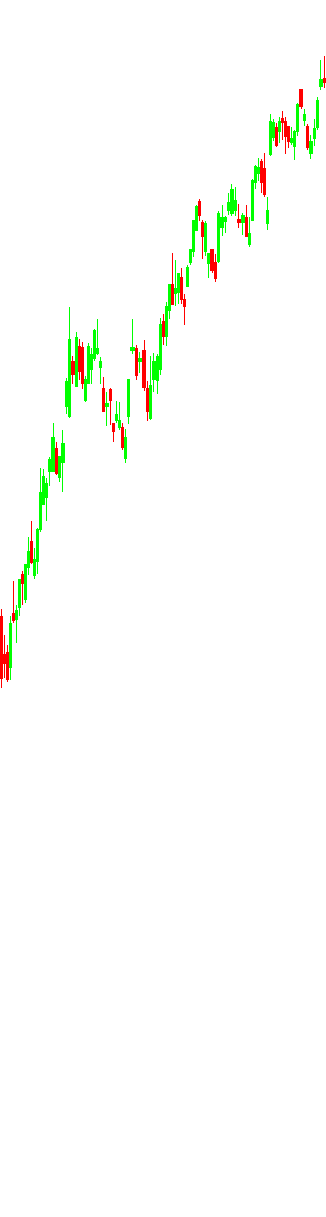

In [31]:
display(Image.open('chart.png'))
